In [1]:
%pip install tensorflow-addons


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# load model 
import numpy as np
import matplotlib.pyplot as plt
import keras
import cv2
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from keras.layers import Dropout, Flatten
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
import pickle
import random
import pandas as pd
import tensorflow as tf


In [3]:
with open('german-traffic-signs/train.p','rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p','rb') as f:
    val_data = pickle.load(f)
with open('german-traffic-signs/test.p','rb') as f:
    test_data = pickle.load(f)

In [4]:
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [5]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"
assert(X_train.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"
assert(X_val.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"
assert(X_test.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"

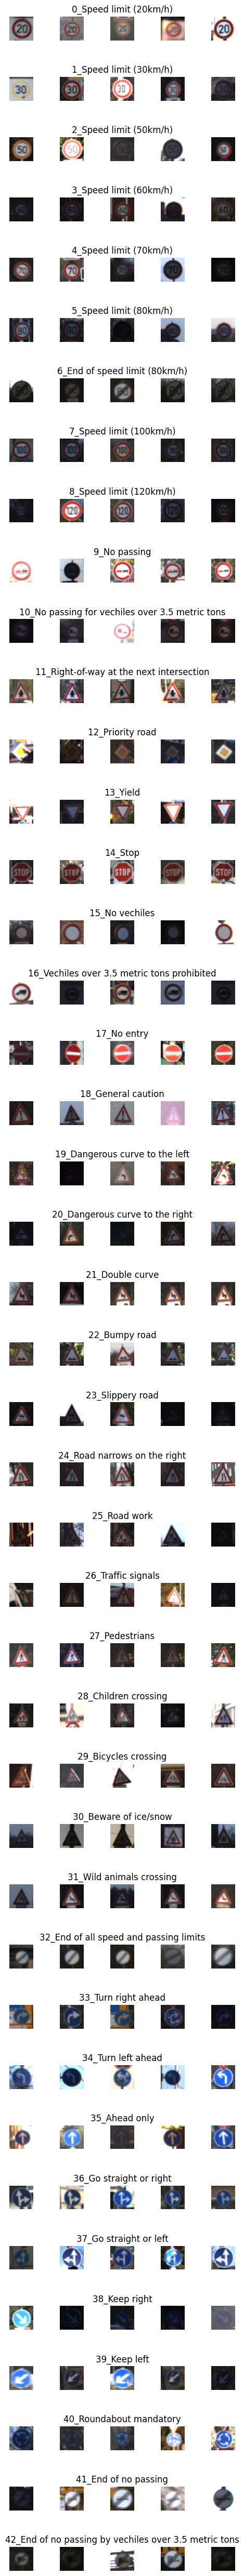

In [6]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
num_of_samples = []
cols = 5
num_classes = 43
fig, axs = plt.subplots(nrows = num_classes, ncols = cols, figsize = (5, 50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, (len(x_selected)-1)), :, :], cmap = plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "_" + row["SignName"])
            num_of_samples.append(len(x_selected))

In [7]:
def grayscale(img):
    if len(img.shape) == 3:  # Check if the image is not already grayscale
        image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        image = img  # If already grayscale, no need to convert
    plt.axis('off')
    return image

(32, 32)


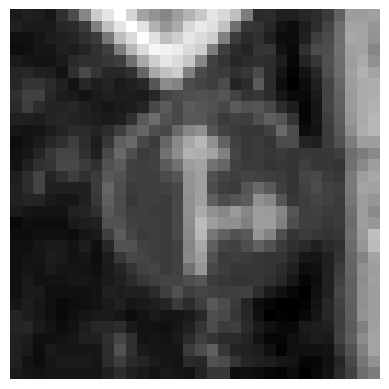

In [8]:
img = grayscale(X_train[1000])
plt.imshow(img, cmap = 'gray')
print(img.shape)

In [9]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

In [10]:
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

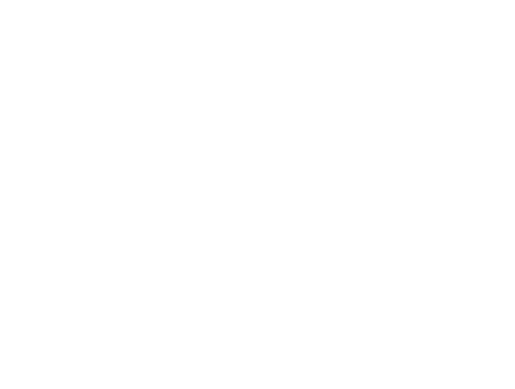

In [11]:
X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

(32, 32)


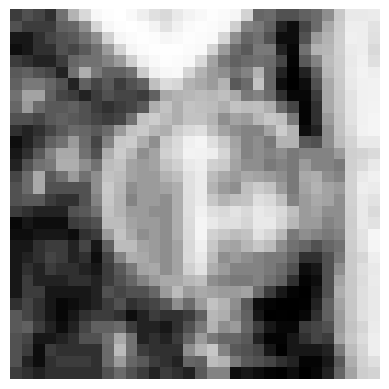

In [12]:
img = equalize(img)
plt.imshow(img, cmap = 'gray')
plt.axis('off')
print(img.shape)

In [13]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range = 0.1,
                  height_shift_range = 0.1,
                   zoom_range = 0.2,
                  shear_range = 0.1,
                  rotation_range = 10)

datagen.fit(X_train)

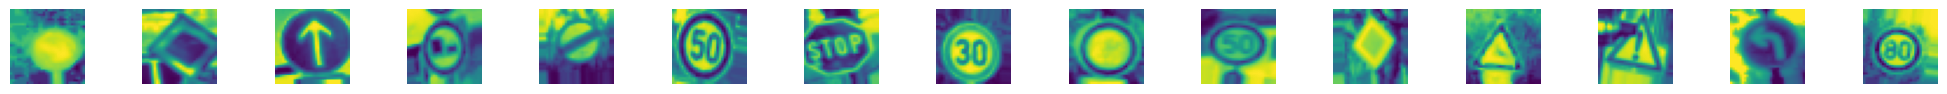

In [15]:
batches = datagen.flow(X_train, y_train, batch_size = 20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize = (20, 5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32, 32))
  axs[i].axis('off')

In [16]:
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

In [19]:
from keras.datasets import mnist
from keras.models import load_model
from keras.losses import CategoricalCrossentropy
from keras.utils.np_utils import to_categorical
from art.estimators.classification import TensorFlowV2Classifier


model = load_model('traffic_sign_classifier.hdf5')
loss_object = CategoricalCrossentropy()
classifier = TensorFlowV2Classifier(clip_values=(0, 1), model=model, nb_classes=10, input_shape=(32, 32, 1), loss_object=loss_object)


C:\Users\mosta\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\mosta\AppData\Roaming\Python\Python310\site-packages\art\estimators\certification\__init__.py:29: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


In [20]:
n = 10000
y_pred = classifier.predict(X_test[:n])
accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_test[:n], axis=1))
print("Accuracy on first %i benign test samples: %f" % (n, accuracy))

Accuracy on first 10000 benign test samples: 0.959600


In [22]:
from art.attacks.evasion import ProjectedGradientDescent

attack = ProjectedGradientDescent(classifier, eps=0.03, eps_step=0.01, max_iter=40, targeted=False, 
                                  num_random_init=True) 

In [26]:
n = 10
X_test_adv = attack.generate(X_test[:n], y=y_test[:n])
y_adv_pred = classifier.predict(X_test_adv)
accuracy = np.mean(np.argmax(y_adv_pred, axis=1) == np.argmax(y_test[:n], axis=1))
print("Accuracy on first %i adversarial test samples: %f" % (n, accuracy))

PGD - Batches: 0it [00:00, ?it/s]

Accuracy on first 10 adversarial test samples: 0.700000
